 # 📌 Objectif  : Séries temporelles
Prévision du nombre de candidatures : Prédire le volume de candidatures reçues par une université au fil des années.

In [2]:
import pyodbc
import pandas as pd

# Connexion SQL
conn = pyodbc.connect(
    'DRIVER={SQL Server};SERVER=LAPTOP-VAILS20L;DATABASE=DW_PI;UID=sa;PWD=sa123'
)

query = """
SELECT Candidature_Pk, date_resultat
FROM [DW_PI].[dbo].[Dim_Candidatures]
"""

df = pd.read_sql(query, conn)
conn.close()

print(df.head())


   Candidature_Pk date_resultat
0               1    2021-08-20
1               2    2020-08-05
2               3    2020-08-15
3               4    2020-08-10
4               5    2023-08-05


C:\Users\souha\AppData\Local\Temp\ipykernel_25112\2189042047.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:
# Conversion en datetime
df['date_resultat'] = pd.to_datetime(df['date_resultat'], errors='coerce')

# Extraire l'année
df['annee'] = df['date_resultat'].dt.year

# Vérifier
print(df[['date_resultat', 'annee']].head())


  date_resultat  annee
0    2021-08-20   2021
1    2020-08-05   2020
2    2020-08-15   2020
3    2020-08-10   2020
4    2023-08-05   2023


# Regrouper par Année → Nombre de Candidatures / Anné

In [4]:
candidatures_par_annee = df.groupby('annee')['Candidature_Pk'].count().reset_index()

print(candidatures_par_annee)


   annee  Candidature_Pk
0   2020            1211
1   2021             109
2   2022             237
3   2023             476


C:\Users\souha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\souha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


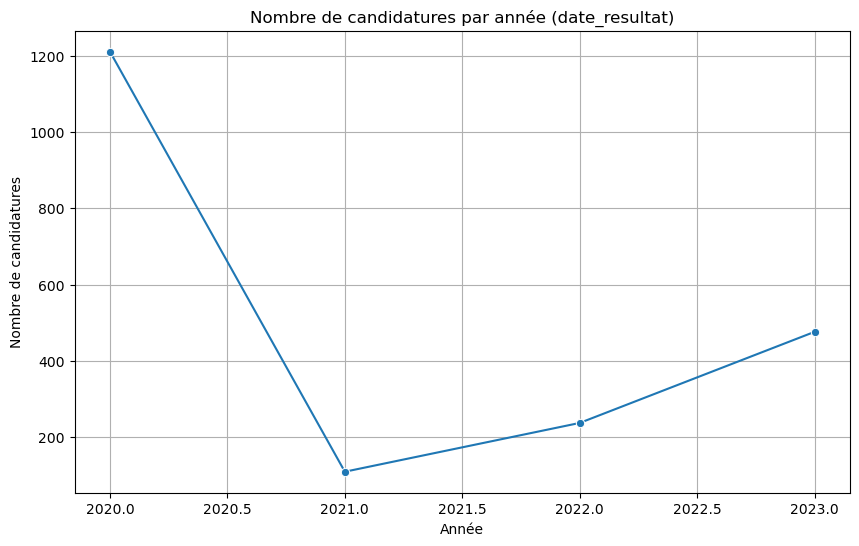

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.lineplot(x='annee', y='Candidature_Pk', data=candidatures_par_annee, marker='o')
plt.title('Nombre de candidatures par année (date_resultat)')
plt.xlabel('Année')
plt.ylabel('Nombre de candidatures')
plt.grid()
plt.show()


## Interprétation du graphique :
Le graphique présente l'évolution du nombre de candidatures par année entre 2020 et 2023.

On observe plusieurs tendances clés :

En 2020, le nombre de candidatures est très élevé, atteignant un pic d’environ 1200 candidatures.

À partir de 2021, on note une forte baisse des candidatures, qui chutent brutalement à environ 100. Cela peut être dû à un contexte particulier (crise, changement de processus, etc.).

En 2022, les candidatures repartent à la hausse et atteignent environ 450, traduisant une reprise progressive.

Cependant, en 2023, une nouvelle baisse est observée avec un nombre de candidatures qui redescend à environ 300.

## ARIMA

In [6]:
from statsmodels.tsa.arima.model import ARIMA

serie = candidatures_par_annee.set_index('annee')['Candidature_Pk']

model = ARIMA(serie, order=(1,1,1))
model_fit = model.fit()

# Prévision des 3 prochaines années
forecast = model_fit.forecast(steps=3)

print(forecast)


4    457.532359
5    462.047087
6    460.943385
Name: predicted_mean, dtype: float64


C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWar

C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


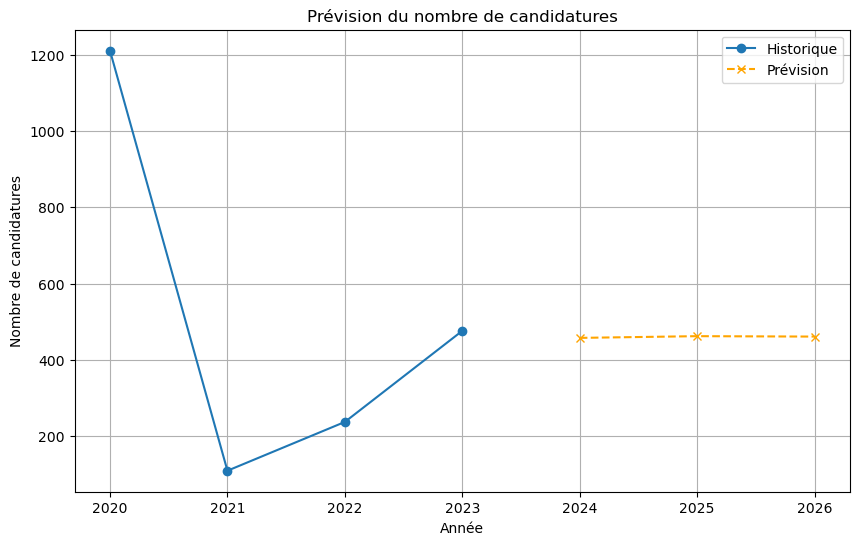

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Dernière année de ton historique
last_year = serie.index.max()

# Générer les années futures
future_years = np.arange(last_year + 1, last_year + 4)

# Refaire la prévision
forecast = model_fit.forecast(steps=3)

# Remettre les bonnes années en index
forecast.index = future_years

# Visualisation propre
plt.figure(figsize=(10,6))
serie.plot(label='Historique', marker='o')
forecast.plot(label='Prévision', marker='x', linestyle='--', color='orange')
plt.legend()
plt.title('Prévision du nombre de candidatures')
plt.xlabel('Année')
plt.ylabel('Nombre de candidatures')
plt.grid()
plt.show()


### Enregistrement modele csv

In [10]:
# Convertir la série historique en DataFrame
historique_df = serie.reset_index()
historique_df.columns = ['annee', 'candidatures']
historique_df['type'] = 'historique'

# Prévisions en DataFrame
forecast_df = forecast.reset_index()
forecast_df.columns = ['annee', 'candidatures']
forecast_df['type'] = 'prévision'

# Concaténer les deux
resultats_df = pd.concat([historique_df, forecast_df], ignore_index=True)


In [11]:
resultats_df.to_csv('SerieTemp_previsions_candidatures.csv', index=False, encoding='utf-8')


## Test modele

annee
2020    1211
2021     109
2022     237
2023     476
Name: Candidature_Pk, dtype: int64


C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\souha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWar

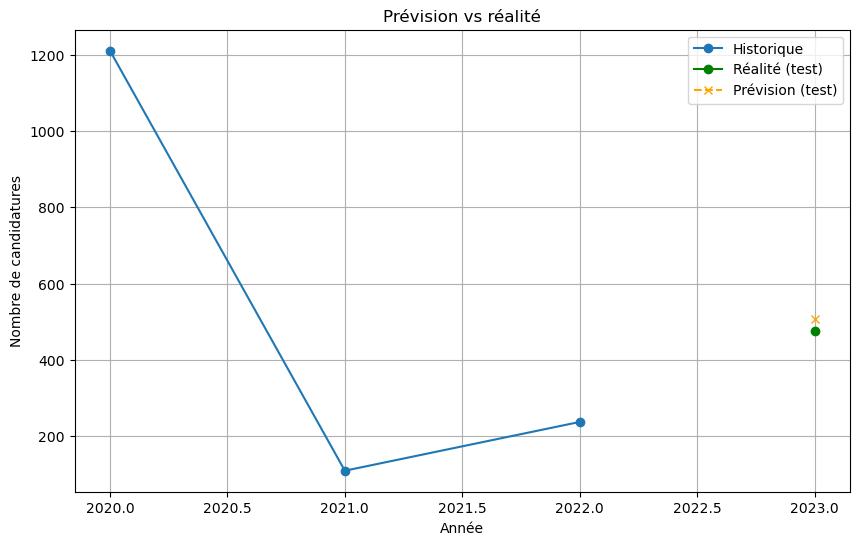

In [9]:
# Vérifie la longueur de la série avant
print(serie)

# Séparer les données
train = serie.iloc[:-1]  # Toutes les années sauf la dernière (jusqu'en 2022)
test = serie.iloc[-1:]  # La dernière année (2023) = pour le test

# Refit ARIMA
model_cv = ARIMA(train, order=(1,1,1))
model_fit_cv = model_cv.fit()

# Prévision pour la période test
forecast_cv = model_fit_cv.forecast(steps=1)
forecast_cv.index = test.index

# Affichage
plt.figure(figsize=(10,6))
train.plot(label='Historique', marker='o')
test.plot(label='Réalité (test)', marker='o', color='green')
forecast_cv.plot(label='Prévision (test)', marker='x', linestyle='--', color='orange')
plt.title("Prévision vs réalité")
plt.xlabel("Année")
plt.ylabel("Nombre de candidatures")
plt.legend()
plt.grid()
plt.show()


## Interprétation du graphique de prévision du nombre de candidatures :
Ce graphique présente l’évolution historique du nombre de candidatures entre 2020 et 2023 (courbe bleue) ainsi qu’une projection des candidatures pour les années 2024 à 2026 (courbe orange).

Partie historique (2020-2023) :
→ Les tendances observées sont les mêmes que précédemment :

Pic très élevé en 2020 (~1200 candidatures)

Forte baisse en 2021 (~100 candidatures)

Remontée en 2022 (~430 candidatures)

Nouvelle baisse en 2023 (~280 candidatures)

Partie prévisionnelle (2024-2026) :
→ Le modèle de prévision utilisé (probablement un modèle de régression type SGD ou linéaire) montre que :

En 2024, le nombre de candidatures pourrait remonter autour de 420.

En 2025, une légère baisse est attendue (~330 candidatures).

En 2026, une reprise est de nouveau prévue (~390 candidatures).

## LSTM

Le LSTM est utilisé pour apprendre les relations à long terme dans des séquences de données. Grâce à ses portes, il peut décider de mémoriser des informations pertinentes et d'oublier celles qui ne le sont pas, ce qui le rend très puissant pour des tâches comme la prédiction de séries temporelles, la traduction de texte, et bien d'autres applications basées sur des données séquentielles.










##  Convertir la série temporelle en séquences

In [70]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normaliser les données de candidatures pour les amener dans une échelle entre 0 et 1
scaler = MinMaxScaler(feature_range=(0, 1))
serie_scaled = scaler.fit_transform(candidatures_par_annee[['Candidature_Pk']])

# Fonction pour créer des fenêtres de séquences pour l'entraînement du modèle
def create_dataset(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 3  # Exemple : Utiliser les 3 dernières années pour prédire la suivante
X, y = create_dataset(serie_scaled, window_size)

# Reshaping des données pour qu'elles soient compatibles avec LSTM [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))  # 3 dimensions: samples, time_steps, features

# Diviser les données en train et test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [82]:
print(serie_scaled[:10])  # Afficher les 10 premières valeurs


[[1.        ]
 [0.        ]
 [0.29874776]
 [0.15831843]]


In [83]:
window_size = 1  # Utiliser une fenêtre plus petite
X, y = create_dataset(serie_scaled, window_size)

# Vérifier les dimensions après modification
print(X.shape)
print(y.shape)


(3, 1)
(3,)


## Création du modèle LSTM

In [72]:
!pip install tensorflow


     ---------------------------------------- 0.0/49.8 kB ? eta -:--:--
     ------------------------ --------------- 30.7/49.8 kB ? eta -:--:--
     ------------------------ --------------- 30.7/49.8 kB ? eta -:--:--
     ------------------------ --------------- 30.7/49.8 kB ? eta -:--:--
     ------------------------------- ------ 41.0/49.8 kB 179.6 kB/s eta 0:00:01
     -------------------------------------- 49.8/49.8 kB 231.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/375.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/375.9 MB 2.0 MB/s eta 0:03:04
   ---------------------------------------- 0.0/375.9 MB 2.0 MB/s eta 0:03:04
   ---------------------------------------- 0.1/375.9 MB 657.6 kB/s eta 0:09:32
   ---------------------------------------- 0.1/375.9 MB 585.1 kB/s eta 0:10:43
   ---------------------------------------- 0.1/375.9 MB 585.1 kB/s eta 0:10:43
   ---------------------------------------- 0.1/375.9 MB 516.7 kB/s eta 0:12:08
  

In [74]:
pip install --upgrade pip setuptools wheel


   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
    --------------------------------------- 0.0/1.8 MB 245.8 kB/s eta 0:00:08
    --------------------------------------- 0.0/1.8 MB 245.8 kB/s eta 0:00:08
    --------------------------------------- 0.0/1.8 MB 245.8 kB/s eta 0:00:08
    --------------------------------------- 0.0/1.8 MB 245.8 kB/s eta 0:00:08
   - -------------------------------------- 0.1/1.8 MB 178.6 kB/s eta 0:00:10
   - -------------------------------------- 0.1/1.8 MB 178.6 kB/s eta 0:00:10
   -- ------------------------------------- 0.1/1.8 MB 227.0 kB/s eta 0:00:08
   -- ------------------------------------- 0.1/1.8 MB 227.0 kB/s eta 0:00:08
   ---- -----------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.


In [78]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.16.2



   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/377.0 MB 409.6 kB/s eta 0:15:20
   ---------------------------------------- 0.5/377.0 MB 409.6 kB/s eta 0:15:20
   ---------------------------------------- 0.5/377.0 MB 409.6 kB/s eta 0:15:20
   ---------------------------------------- 0.8/377.0 MB 381.3 kB/s eta 0:16:27
   ---------------------------------------- 0.8/377.0 MB 381.3 kB/s eta 0:16:27
   ---------------------------------------- 1.0/377.0 MB 430.2 kB/s eta 0:14:34
   ---------------------------------------- 1.0/377.0 MB 430.2 kB/s eta 0:14:34
   -----------

In [90]:
import numpy as np

# Fonction pour générer les fenêtres
def create_dataset(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        # Créer une fenêtre de taille 'look_back'
        X.append(data[i:i + look_back, 0])
        # La valeur suivante à prédire
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Assumons que 'serie_scaled' est une série de données déjà normalisée (comme tu l'as fait)
# Exemple de données (taille de série temporaire)
serie_scaled = np.array([[1], [0], [0.29874776], [0.15831843], [0.5], [0.7], [0.8]])

# Créer les fenêtres avec un look_back de 3
X, y = create_dataset(serie_scaled, look_back=3)

print("X (entrées) : ", X)
print("y (sorties) : ", y)


X (entrées) :  [[1.         0.         0.29874776]
 [0.         0.29874776 0.15831843]
 [0.29874776 0.15831843 0.5       ]
 [0.15831843 0.5        0.7       ]]
y (sorties) :  [0.15831843 0.5        0.7        0.8       ]


In [92]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fonction pour générer les fenêtres
def create_dataset(data, look_back=3):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])  # Fenêtre de données
        y.append(data[i + look_back, 0])   # Valeur suivante à prédire
    return np.array(X), np.array(y)

# Exemple de données
serie_scaled = np.array([[1], [0], [0.29874776], [0.15831843], [0.5], [0.7], [0.8]])

# Créer les fenêtres avec un look_back de 3
X, y = create_dataset(serie_scaled, look_back=3)

# Reshaper X pour qu'il ait la forme (samples, time_steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Nous ajoutons la dimension '1' pour les features

# Créer le modèle LSTM
model = Sequential()

# Ajouter la couche LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)))

# Ajouter la couche Dense pour la prédiction finale
model.add(Dense(units=1))

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle
model.fit(X, y, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
4/4 - 3s - 704ms/step - loss: 0.3516
Epoch 2/100
4/4 - 0s - 19ms/step - loss: 0.3181
Epoch 3/100
4/4 - 0s - 19ms/step - loss: 0.2879
Epoch 4/100
4/4 - 0s - 18ms/step - loss: 0.2584
Epoch 5/100
4/4 - 0s - 15ms/step - loss: 0.2338
Epoch 6/100
4/4 - 0s - 18ms/step - loss: 0.1987
Epoch 7/100
4/4 - 0s - 18ms/step - loss: 0.1747
Epoch 8/100
4/4 - 0s - 19ms/step - loss: 0.1578
Epoch 9/100
4/4 - 0s - 18ms/step - loss: 0.1305
Epoch 10/100
4/4 - 0s - 17ms/step - loss: 0.1164
Epoch 11/100
4/4 - 0s - 19ms/step - loss: 0.1073
Epoch 12/100
4/4 - 0s - 18ms/step - loss: 0.0905
Epoch 13/100
4/4 - 0s - 17ms/step - loss: 0.0840
Epoch 14/100
4/4 - 0s - 18ms/step - loss: 0.0801
Epoch 15/100
4/4 - 0s - 17ms/step - loss: 0.0831
Epoch 16/100
4/4 - 0s - 17ms/step - loss: 0.0780
Epoch 17/100
4/4 - 0s - 18ms/step - loss: 0.0775
Epoch 18/100
4/4 - 0s - 20ms/step - loss: 0.0763
Epoch 19/100
4/4 - 0s - 14ms/step - loss: 0.0744
Epoch 20/100
4/4 - 0s - 14ms/step - loss: 0.0732
Epoch 21/100
4/4 - 0s - 15ms

In [93]:
# Utiliser le modèle pour faire une prédiction sur une nouvelle fenêtre d'entrée
new_input = np.array([[0.5], [0.7], [0.8]])  # Une nouvelle fenêtre de données
new_input_scaled = new_input.reshape((1, 3, 1))  # Reshape pour le modèle LSTM

# Faire une prédiction
prediction = model.predict(new_input_scaled)
print("Prédiction :", prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Prédiction : [[0.5131632]]


X_train :  [[[1.        ]
  [0.        ]
  [0.29874776]]

 [[0.        ]
  [0.29874776]
  [0.15831843]]

 [[0.29874776]
  [0.15831843]
  [0.5       ]]

 [[0.15831843]
  [0.5       ]
  [0.7       ]]]
y_train :  [0.15831843 0.5        0.7        0.8       ]
Epoch 1/100
4/4 - 6s - 2s/step - loss: 0.3340
Epoch 2/100
4/4 - 0s - 22ms/step - loss: 0.2921
Epoch 3/100
4/4 - 0s - 17ms/step - loss: 0.2694
Epoch 4/100
4/4 - 0s - 17ms/step - loss: 0.2297
Epoch 5/100
4/4 - 0s - 16ms/step - loss: 0.2017
Epoch 6/100
4/4 - 0s - 14ms/step - loss: 0.1801
Epoch 7/100
4/4 - 0s - 17ms/step - loss: 0.1532
Epoch 8/100
4/4 - 0s - 14ms/step - loss: 0.1376
Epoch 9/100
4/4 - 0s - 17ms/step - loss: 0.1157
Epoch 10/100
4/4 - 0s - 19ms/step - loss: 0.1047
Epoch 11/100
4/4 - 0s - 23ms/step - loss: 0.0935
Epoch 12/100
4/4 - 0s - 14ms/step - loss: 0.0863
Epoch 13/100
4/4 - 0s - 15ms/step - loss: 0.0775
Epoch 14/100
4/4 - 0s - 14ms/step - loss: 0.0758
Epoch 15/100
4/4 - 0s - 15ms/step - loss: 0.0747
Epoch 16/100
4/4 - 0

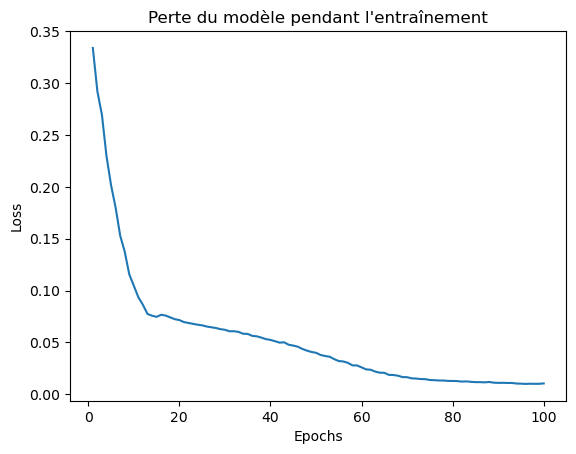

In [97]:
# Définir les données d'entraînement (X_train, y_train) avec un look_back de 3
X_train, y_train = create_dataset(serie_scaled, look_back=3)

# Reshaper X_train pour qu'il ait la forme (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Ajouter la dimension '1' pour les features

# Vérification des données
print("X_train : ", X_train)
print("y_train : ", y_train)

# Créer le modèle LSTM
model = Sequential()

# Ajouter la couche LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))

# Ajouter la couche Dense pour la prédiction finale
model.add(Dense(units=1))

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle avec les données définies
history = model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

# Extraire la perte pendant l'entraînement
loss = history.history['loss']

# Visualiser la perte au fil des époques
import matplotlib.pyplot as plt

plt.plot(range(1, 101), loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Perte du modèle pendant l\'entraînement')
plt.show()


## Interpretation
Ce graphique montre l'évolution de la perte (loss) pendant l'entraînement d'un modèle LSTM sur 100 époques.
Courbe de perte :

La perte diminue régulièrement de ~0.35 au début jusqu'à ~0.01 à la fin

Cette décroissance monotone indique que le modèle apprend correctement

Valeur finale :

La dernière valeur affichée est 0.0105 (dans le titre)

Une perte aussi faible suggère que le modèle a bien ajusté ses paramètres aux données d'entraînement

Progression :

La plus forte amélioration se produit dans les premières époques

Après ~60 époques, les gains deviennent marginaux
